# Create a Usable Dataset & Observe Member Breakdown and Average Ride Duration 
This notebook will organize the raw B-Cycle dataset into one with 10 consolidated Member Types. 

The consolidated dataset will be used to show: 
- Member Type breakdown per year from 2014 to 2018 
- Avereage ride duration over each year from 2014 to 2018 

Ultimately, this notebok aims to observe the associated average ride duration for each member type. 

In [3]:
import warnings
warnings.simplefilter("ignore")
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
import dateutil 
import scipy 
from scipy import stats
%matplotlib inline


In [4]:
# read csv data 
data = pd.read_csv("Austin_B-Cycle_Trips.csv")
print(data.shape)
data.head(10)

(1047118, 6)


,Membership Type,Checkout Date,Checkout Time,Checkout Kiosk,Return Kiosk,Trip Duration Minutes
0,24-Hour Kiosk (Austin B-cycle),1/1/2014,0:12:00,4th & Congress,Barton Springs & Riverside,20
1,24-Hour Kiosk (Austin B-cycle),1/1/2014,0:12:00,4th & Congress,Barton Springs & Riverside,19
2,24-Hour Kiosk (Austin B-cycle),1/1/2014,0:12:00,4th & Congress,Barton Springs & Riverside,17
3,24-Hour Kiosk (Austin B-cycle),1/1/2014,0:12:00,Convention Center / 4th St. @ MetroRail,Convention Center / 4th St. @ MetroRail,8
4,24-Hour Kiosk (Austin B-cycle),1/1/2014,2:12:00,Convention Center / 4th St. @ MetroRail,Barton Springs & Riverside,18
5,24-Hour Kiosk (Austin B-cycle),1/1/2014,2:12:00,Convention Center / 4th St. @ MetroRail,Barton Springs & Riverside,17
6,24-Hour Kiosk (Austin B-cycle),1/1/2014,2:12:00,Convention Center / 4th St. @ MetroRail,Barton Springs & Riverside,48
7,24-Hour Kiosk (Austin B-cycle),1/1/2014,2:12:00,8th & Congress,South Congress & James,15
8,24-Hour Kiosk (Austin B-cycle),1/1/2014,2:12:00,8th & Congress,South Congress & James,14
9,24-Hour Kiosk (Austin B-cycle),1/1/2014,3:12:00,8th & Congress,5th & Bowie,21


# Value Counts for Membership Types 
- Creating major membership types for total breakdown 

In [5]:
# read csv data 

#Take a look at different raw membership types 
vc = data['Membership Type'].value_counts() # value counts 
vn = data['Membership Type'].value_counts().index.tolist() # value names 

raw_pairs = []
for i in range(len(vc)):
    raw_pairs.append([vn[i],vc[i]])

print(vc) # value counts 

Walk Up                                          373876
U.T. Student Membership                          201930
Local365                                         171409
24-Hour Kiosk (Austin B-cycle)                   107376
Local30                                           56004
Weekender                                         44932
Annual Membership (Austin B-cycle)                30234
Explorer                                          15485
Local365+Guest Pass                               11125
Local365 ($80 plus tax)                            4005
Founding Member                                    3550
7-Day                                              3137
7-Day Membership (Austin B-cycle)                  2747
Founding Member (Austin B-cycle)                   2716
Semester Membership (Austin B-cycle)               2426
Annual                                             1138
Semester Membership                                 900
Local30 ($11 plus tax)                          

## 6344 Membership Types are NaN. 

I didn't explicitly drop the NaN rows (yet) since 6k/1M is .006. 

Given the code below, I assumed the NaN rows would not be counted since they are not marked in the 'Other' Member Type. 
 

In [6]:
count_nan = len(data) - data.count()

print(count_nan) # show num NaN 

# drop NaN rows
#data = data.dropna()

Membership Type          6344
Checkout Date               0
Checkout Time               0
Checkout Kiosk              0
Return Kiosk                0
Trip Duration Minutes       0
dtype: int64


# Define Main Membership
- There are too many member types (almost 60!) from the information shown above
- Sort raw data's Member Types into main_members categories 
- Rename the raw data entries into main_members cetegories 

In [7]:
# need to merge this data into B-Cycle main membership types   
main_members = ['Explorer', # 24 hour pass: 24-Hour, Explorer 
               'Weekender', # 3 day pass
               'SevenDay', # one week pass 
               'Local30', # monthly pass 
               'Local365', # annual pass 
               'Local365guest', #annual pass with a guest 
               'Student', # UT Austin, HT Ram (HBCU) student pass 
               'National', # different city membership
               'Once', # walk up or one-time use 
               'Other'] # every other pass type 
# B Cycle-for-all was not found in the csv file 

exp, nat, wnd, week, l30, l365g, l365, stu, one, oth = [],[],[],[],[],[],[],[],[],[]

#hardcoding due to specificity 
other_cities = ['Annual (San Antonio B-cycle)',
               'Annual Member (Houston B-cycle)',
               'Annual Membership (Fort Worth Bike Sharing)',
               'Republic Rider (Annual)',
               'Republic Rider',
               'Annual (Denver B-cycle)',
               'Annual (Madison B-cycle)',
               'Annual (Broward B-cycle)',
               'Annual (Denver Bike Sharing)',
               'Annual (Boulder B-cycle)',
               'Annual (Cincy Red Bike)',
               'Annual (Kansas City B-cycle)',
               'Madtown Monthly',
               'Annual (Nashville B-cycle)',
               'Annual Membership (Charlotte B-cycle)',
               'Annual Membership (Indy - Pacers Bikeshare )',
               'Annual (Omaha B-cycle)'] 

# sort raw data entries into the major membership types 
def sort_member(entry): 
    # entry == [vn , vc]
    if ("24" in entry[0]) or ('Explorer' in entry[0]):
        # 24-Hour, Explorer 
        exp.append(entry[1]) 
        
    elif (entry[0] in other_cities):
        # other_cities 
        nat.append(entry[1])
        
    elif ("Weekend" in entry[0]): 
        # weekender, 
        wnd.append(entry[1])
        
    elif ("7" in entry[0]):
        # 7-day
        week.append(entry[1])
        
    elif ("30" in entry[0]):
        # local30 
        l30.append(entry[1])
    
    elif('Local365+Guest Pass' == entry[0]):
        l365g.append(entry[1])
    
    elif ("Annual" in entry[0]) or ("Local365" in entry[0]) or('one-year' in entry[0]): 
        # Annual... , Local365..., one-year committment 
        l365.append(entry[1]) 
    
    elif ("HT" in entry[0]) or ("Semester" in entry[0]) or ("Student" in entry[0]):
        #HT ram, semester, UT
        stu.append(entry[1]) 
        
        
    elif("Walk" in entry[0]):
        #walk up 
        one.append(entry[1])
        
    else: 
        # festivals, try before you buy, ridescout (app dev), founders,aluminum
        #prohibited, restricted 
        oth.append(entry[1])

# update member naming in dataframe 
# Explorer 
data['Membership Type'] = data['Membership Type'].replace('24-Hour Kiosk (Austin B-cycle)', 'Explorer')
data['Membership Type'] = data['Membership Type'].replace('24-Hour Membership (Austin B-cycle)', 'Explorer')
data['Membership Type'] = data['Membership Type'].replace('Explorer ($8 plus tax)', 'Explorer')
data['Membership Type'] = data['Membership Type'].replace('24-Hour-Online (Austin B-cycle)', 'Explorer')

#National
for i in other_cities: 
    data['Membership Type'] = data['Membership Type'].replace(i, 'National')

#Weekender
data['Membership Type'] = data['Membership Type'].replace('Weekender ($15 plus tax)', 'Weekender')

#SevenDay
data['Membership Type'] = data['Membership Type'].replace('7-Day', 'SevenDay')
data['Membership Type'] = data['Membership Type'].replace('7-Day Membership (Austin B-cycle)', 'SevenDay')

#local30
data['Membership Type'] = data['Membership Type'].replace('Local30', 'Local30')
data['Membership Type'] = data['Membership Type'].replace('Local30 ($11 plus tax)', 'Local30')

#Local365guest
data['Membership Type'] = data['Membership Type'].replace('Local365+Guest Pass', 'Local365guest')
data['Membership Type'] = data['Membership Type'].replace('Local365+Guest Pass', 'Local365guest')

#Local365
data['Membership Type'] = data['Membership Type'].replace('Local365 ($80 plus tax)', 'Local365')
data['Membership Type'] = data['Membership Type'].replace('Annual', 'Local365')
data['Membership Type'] = data['Membership Type'].replace('Annual ', 'Local365')
data['Membership Type'] = data['Membership Type'].replace('Annual Plus', 'Local365')
data['Membership Type'] = data['Membership Type'].replace('Local365 Youth (age 13-17 riders)', 'Local365')
data['Membership Type'] = data['Membership Type'].replace('Local365 Youth with helmet (age 13-17 riders)', 'Local365')
data['Membership Type'] = data['Membership Type'].replace('Annual Membership (GREENbike)', 'Local365')
data['Membership Type'] = data['Membership Type'].replace('Annual Pass', 'Local365')
data['Membership Type'] = data['Membership Type'].replace('Annual Plus Membership', 'Local365')
data['Membership Type'] = data['Membership Type'].replace('Membership: pay once  one-year commitment', 'Local365')
data['Membership Type'] = data['Membership Type'].replace('Annual Membership (Austin B-cycle)', 'Local365')
data['Membership Type'] = data['Membership Type'].replace('Annual Member', 'Local365')
data['Membership Type'] = data['Membership Type'].replace('Annual Membership', 'Local365')

#Student
data['Membership Type'] = data['Membership Type'].replace('U.T. Student Membership', 'Student')
data['Membership Type'] = data['Membership Type'].replace('Semester Membership (Austin B-cycle)', 'Student')
data['Membership Type'] = data['Membership Type'].replace('Semester Membership', 'Student')
data['Membership Type'] = data['Membership Type'].replace('HT Ram Membership', 'Student')
data['Membership Type'] = data['Membership Type'].replace('UT Student Membership', 'Student')

#Once 
data['Membership Type'] = data['Membership Type'].replace('Walk Up', 'Once')

#Other 
data['Membership Type'] = data['Membership Type'].replace('Founding Member', 'Other')
data['Membership Type'] = data['Membership Type'].replace('Founding Member (Austin B-cycle)', 'Other')
data['Membership Type'] = data['Membership Type'].replace('Denver B-cycle Founder', 'Other')
data['Membership Type'] = data['Membership Type'].replace('PROHIBITED', 'Other')
data['Membership Type'] = data['Membership Type'].replace('Try Before You Buy Special', 'Other')
data['Membership Type'] = data['Membership Type'].replace('RideScout Single Ride', 'Other')
data['Membership Type'] = data['Membership Type'].replace('ACL Weekend Pass Special (Austin B-cycle)', 'Other')
data['Membership Type'] = data['Membership Type'].replace('Aluminum Access', 'Other')
data['Membership Type'] = data['Membership Type'].replace('FunFunFun Fest 3 Day Pass', 'Other')
data['Membership Type'] = data['Membership Type'].replace('RESTRICTED', 'Other')
data['Membership Type'] = data['Membership Type'].replace('PROHIBITED', 'Other')

## Aggregate Member Data
Create arrays containing the total number of entries for each member type 

In [8]:
for entry in raw_pairs: 
    sort_member(entry)
    
total_explorer = sum(exp) 
total_national = sum(nat)
total_weekend = sum(wnd) 
total_week = sum(week) 
total_monthly = sum(l30)
total_annualguest = sum(l365g)
total_annual = sum(l365) 
total_student = sum(stu)
total_oneday = sum(one)
total_other = sum(oth) 

aggregate_total= [total_explorer, total_national,total_weekend, total_week ,total_monthly ,total_annualguest ,total_annual,total_student,total_oneday,total_other]

## Yearly Member Data
Print a yearly breakdown for the main Membership Types 

In [9]:
# Pie breakdown per year 
years = [2014,2015,2016,2017,2018]
years_counts=[] 
yearly_Explorer,yearly_Local30,yearly_Local365,yearly_National,yearly_Once,yearly_Other,yearly_SevenDay,yearly_Student,yearly_Weekender = [],[],[],[],[],[],[],[],[]   

for i in years:  
    # for each year, create a total user count 
    print(i) 
    yr = data[data['Checkout Date'].str.contains(str(i))] # one year at a time 
    sortedcount = yr['Membership Type'].value_counts().sort_index() 
    years_counts.append(yr['Membership Type'].count()) 
    print('sorted count')
    print(sortedcount)
    print() 
    #print(ctz)
    print(years_counts)
    print('\n\n')
   
    try: 
        j = 0 
        if(sortedcount.index[j]=='Explorer'):
            yearly_Explorer.append(sortedcount[j])
        else: 
            yearly_Explorer.append(0)
            
        j+=1
        if(sortedcount.index[j]=='Local30'):
            yearly_Local30.append(sortedcount[j])
        else: 
            yearly_Local30.append(0)
    
        j+=1
        if(sortedcount.index[j]=='Local365'):
            yearly_Local365.append(sortedcount[j])
        else: 
            yearly_Local365.append(0)

            
        j+=1
        if(sortedcount.index[j]=='National'):
            yearly_National.append(sortedcount[j])
        else: 
            yearly_National.append(0)
            
        j+=1
        if(sortedcount.index[j]=='Once'):
            yearly_Once.append(sortedcount[j])
        else: 
            yearly_Once.append(0)
            
        j+=1
        if(sortedcount.index[j]=='Other'):
            yearly_Other.append(sortedcount[j]) 
        else: 
            yearly_Other.append(0)
            
        j+=1
        if(sortedcount.index[j]=='SevenDay'):
            yearly_SevenDay.append(sortedcount[j])
        else: 
            yearly_SevenDay.append(0)
        
        j+=1
        if(sortedcount.index[j]=='Student'):
            yearly_Student.append(sortedcount[j])
        else: 
            yearly_Student.append(0)
        
        j+=1
        if(sortedcount.index[j]=='Weekender'):
            yearly_Weekender.append(sortedcount[j]) 
        else: 
            yearly_Weekender.append(0)
        
        
    except: # Weekender available after 2014 
                
        if(j == 0): 
            yearly_Explorer.append(0)
        if(j == 1): 
            yearly_Local30.append(0)
        if(j == 2): 
            yearly_Local365.append(0)
        if(j == 3): 
            yearly_National.append(0)
        if(j == 4): 
            yearly_Once.append(0)
        if(j == 5): 
            yearly_Other.append(0)
        if(j == 6): 
            yearly_SevenDay.append(0)
        if(j == 7): 
            yearly_Student.append(0)
        if(j == 8): 
            yearly_Weekender.append(0)
            
            
yearly=(yearly_Explorer,yearly_Local30,yearly_Local365,yearly_National,yearly_Once,yearly_Other,yearly_SevenDay,yearly_Student,yearly_Weekender)

for a in yearly: 
    print(a)
    print()   
    

2014
sorted count
Explorer    108194
Local30         18
Local365     32379
National      1177
Once          4644
Other         3438
SevenDay      2874
Student       2979
Name: Membership Type, dtype: int64

[155703]



2015
sorted count
Explorer       2456
Local30       12827
Local365      46585
National        722
Once         111917
Other          2216
SevenDay       3005
Student         347
Weekender      4446
Name: Membership Type, dtype: int64

[155703, 184521]



2016
sorted count
Explorer       2898
Local30       13223
Local365      51619
National         37
Once         106599
Other          1765
SevenDay          5
Weekender      8534
Name: Membership Type, dtype: int64

[155703, 184521, 184680]



2017
sorted count
Explorer          5151
Local30          18413
Local365         49695
Local365guest     6067
National           110
Once             92448
Other              151
Weekender        19380
Name: Membership Type, dtype: int64

[155703, 184521, 184680, 191415]



2018
sor

# Analysis: 
The outputted data shows that B-Cycle has grown tremendously over this 4 year span, but there is no one main member type behind that growth. From the checkout counts shown, each year has a majority member type that comprises of over 50% of the checkouts for that year. 
- The notion that users are converting to Annual pass holders may be inaccurate since the Local365 counts don't experience significant growth. In some cases, they experience decline from a year prior. 


# Concern:
The outputted data shows an inconsistency in certain membertypes being recorded per year. 

For instance: 
- Weekender member type is not mentioned in 2014
- Student member type is not mentioned at all in 2016 or 2017

The Weekender concern might be explained if Austin B-Cycle introduced the type after 2014, but the missing Student values are concerning. 
- Did B-Cycle organize student memberships into another membership type?
- Did Austin B-Cycle remove the student discounts altogether?  
- Did Austin B-Cycle change how it classified members in general every few years? 

The data henceforth should be considered with caution. 

# General Breakdown of Usage by Member Type
- Pie Chart using MatPlotLib
- From Jan 1, 2014 to Oct 14, 2018
- Dates extend beyond weather dataset 

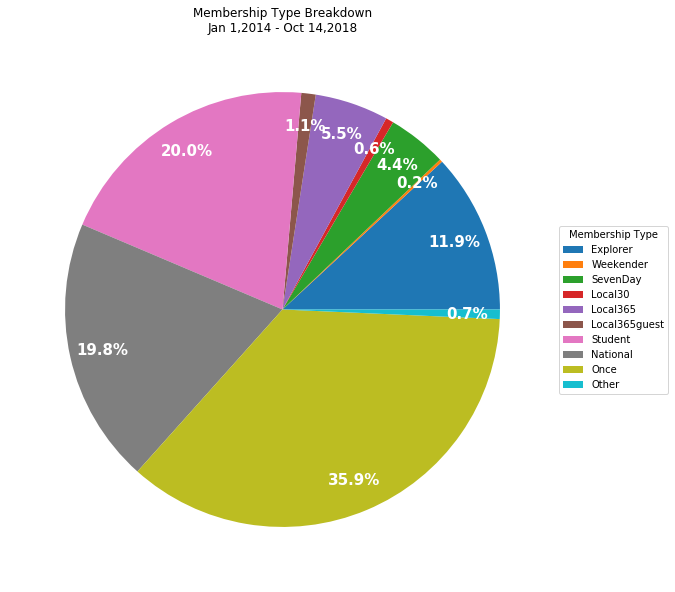

In [10]:
fig, ax = plt.subplots(figsize=(20, 10), subplot_kw=dict(aspect="equal"))
labels = main_members 
sizes = aggregate_total 

def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%".format(pct, absolute)

wedges, texts, autotexts = ax.pie(sizes, pctdistance=.85,autopct=lambda pct: func(pct, sizes),
                                  textprops=dict(color="w"))

ax.legend(wedges, labels,
          title="Membership Type",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

plt.setp(autotexts, size=15, weight="bold")
ax.set_title("Membership Type Breakdown\nJan 1,2014 - Oct 14,2018")
plt.show()

# Membership Breakdown Over Time
- Plot the breakdown of Member Types from 2014 to 2018 
- Oberserve the main consumer groups for B-Cycle 

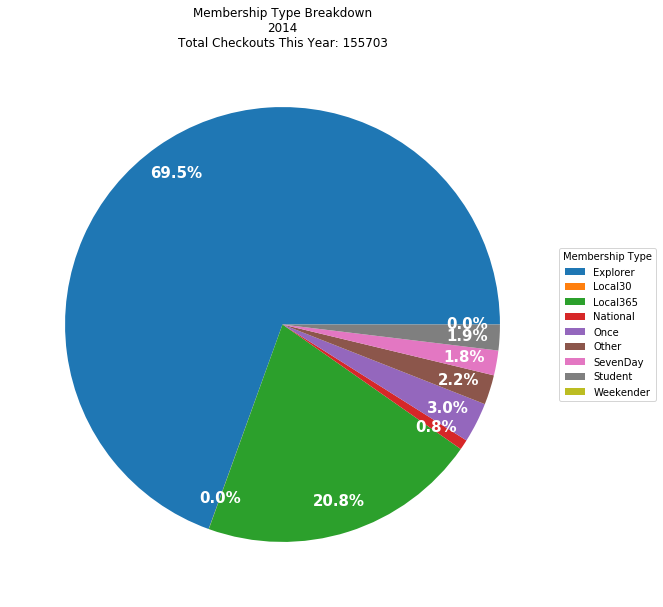

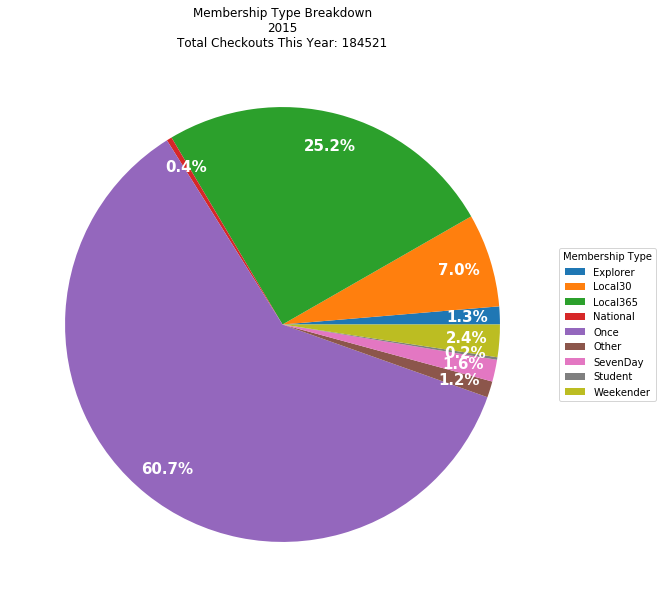

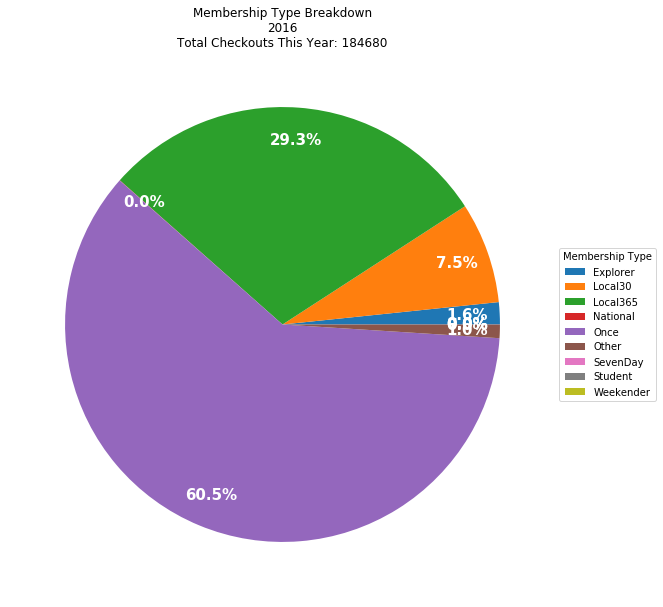

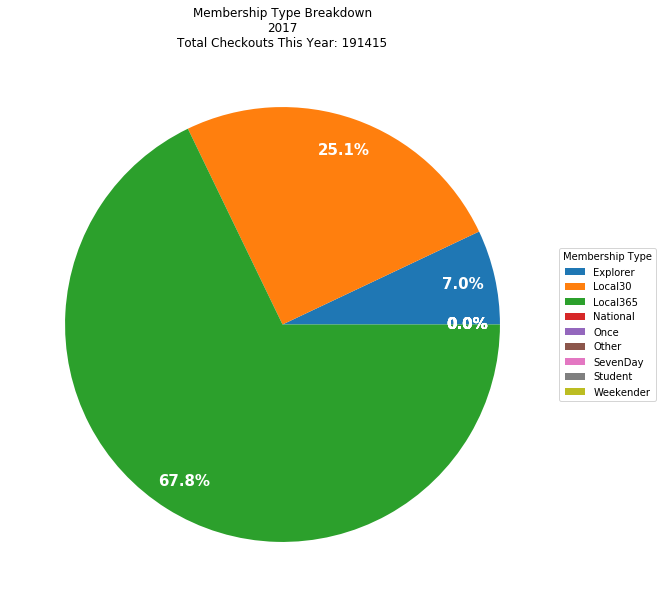

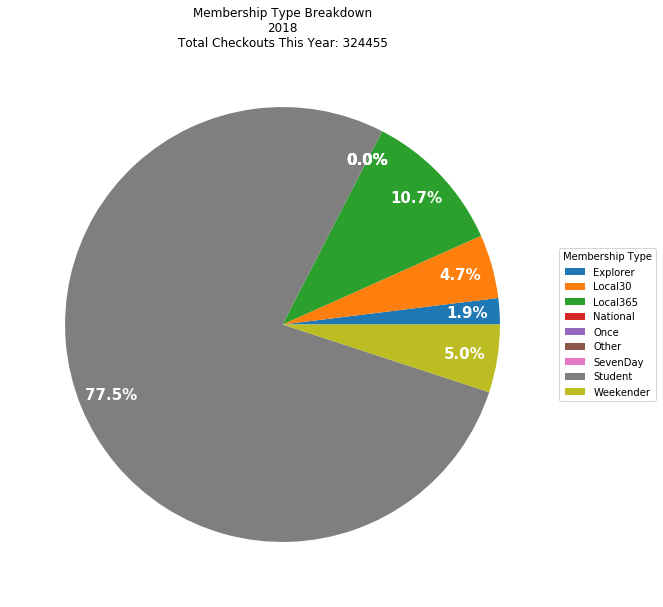

In [11]:
yearly_names = ['Explorer', 'Local30','Local365','National','Once','Other','SevenDay','Student','Weekender']

i=0 
for year in years: 
    sizes = [] 
    for j in range(len(yearly)):
        sizes.append(yearly[j][i])

    fig, ax = plt.subplots(figsize=(20, 10), subplot_kw=dict(aspect="equal"))
    labels = yearly_names 
    sizes = sizes 

    wedges, texts, autotexts = ax.pie(sizes, pctdistance=.85,autopct=lambda pct: func(pct, sizes),
                                  textprops=dict(color="w"))

    ax.legend(wedges, labels,
              title="Membership Type",
              loc="center left",
              bbox_to_anchor=(1, 0, 0.5, 1))

    plt.setp(autotexts, size=15, weight="bold")
    ax.set_title("Membership Type Breakdown\n" + str(year) + "\nTotal Checkouts This Year: " + str(years_counts[i])) 
    i+=1 
    plt.show()

# Analysis: 
## Aggregate: 
About 75% of Austin B-Cycle's aggregate usage comes from one-time users, national visitors with passes, and students. 

However, this set may not be indicative of future use since Austin B-Cycle has increased the price of student membership from free to $1. We anticipate that raising the cost for a college demographic could adversely impact usage rates. 

Less than 25% of Austin B-Cycle's aggregate member share is comprised of 24-hour, weekend, weekly, and annual passes. 



## Yearly: 
Every year, there seems to be one majority Member Type: 2014 was the Explorer, 2015 and 2016 were One-Time, 2017 was Annual, and the 2018 data suggested the Student group. 

B-Cycle has seen enormous growth in this four year span, more than doubling in annual checkouts from 2014 to (up until October) 2018. There were two spikes in B-Cycle's annual checkout growth: a 30k jump from 2014 to 2015, and a 133k jump from 2017 to 2018. This growth is especially promising since the 2018 data is from January to October. 


## Continued Concern: 
The yearly data shows an inconsistency in certain member types being recorded per year. 


The yearly pie charts show entire member types not recorded at all for certain years.   
- Did B-Cycle organize student memberships into another membership type (perhapd the Annual group?) 
- Did Austin B-Cycle remove the some member types and then add them back (internal restructuring)?  

There is no record from B-Cycle's end to explain these inconsistencies, so the data should be considered with caution. 

# Another Look at the Aggregate Data

- This section will observe ride time data 

In [12]:
print('Longest trip duration is:', data['Trip Duration Minutes'].max(), "minutes. That's about", round(data['Trip Duration Minutes'].max()/1440) , "days!") 
print('Average trip duration is:', round(data['Trip Duration Minutes'].mean(),3), 'minutes.\n') 

# Use 3 columns 
d1 = data[['Membership Type', 'Checkout Date','Trip Duration Minutes']]

# format checkout date into DateTime--> needed for chrono. graphing 
d1['Checkout Date'] = d1['Checkout Date'].apply(dateutil.parser.parse, dayfirst=True)


d1.groupby('Checkout Date') 
#d1.head()  

d1['Membership Type'].value_counts()

Longest trip duration is: 21296 minutes. That's about 15.0 days!
Average trip duration is: 27.217 minutes.



Once             373876
Local365         208292
Student          205655
Explorer         123785
Local30           56844
Weekender         45498
Local365guest     11125
Other              7629
SevenDay           5884
National           2186
Name: Membership Type, dtype: int64

### Update the DF to reflect daily average use for each main membership type. This data will then be plotted against each other. 

In [13]:
q1 = d1.groupby(['Checkout Date','Membership Type']).mean()[['Trip Duration Minutes']]
q1.head(100) 

Trip Duration Minutes
Checkout Date Membership Type                       
2014-01-01    Explorer                     43.991770
              Local365                     33.857143
              National                     11.333333
              Other                         8.000000
              SevenDay                     13.000000
2014-01-02    Explorer                     40.402985
              Local365                      8.500000
              SevenDay                     29.000000
2014-01-03    Explorer                     46.774900
              Local365                     11.518519
              National                      9.500000
              Other                         5.000000
              SevenDay                     16.100000
              Student                      10.200000
2014-01-04    Explorer                     94.729323
              Local365                      7.132075
              National                      4.000000
              Other                         8.666667
              SevenDay                     34.000000
              Student                       9.800000
2014-01-05    Explorer                     36.454545
              Local365                      8.600000
              National                     10.333333
              Other                         7.133333
              Student                       6.375000
2014-01-06    Explorer                     31.210630
              Local365                     10.727273
              National                     20.125000
              Other                        12.200000
              SevenDay                     19.800000
...                                              ...
2014-01-14    Local365                      8.777778
              Other                         5.500000
              SevenDay                      7.750000
2014-01-15    Explorer                     43.550000
              Local365                      6.827586
              National                      6.000000
              Other                         6.045455
              SevenDay                      8.222222
2014-01-16    Explorer                     34.418605
              Local365                      6.644444
              National                      4.500000
              Other                         6.545455
              SevenDay                     18.714286
2014-01-17    Explorer                     28.118644
              Local365                      8.967742
              Other                         7.625000
              SevenDay                      8.833333
2014-01-18    Explorer                     45.022026
              Local365                     14.555556
              National                     14.000000
              Other                         6.000000
              SevenDay                     11.600000
2014-01-19    Explorer                     38.994737
              Local365                     10.812500
              SevenDay                     13.000000
2014-01-20    Explorer                     68.558333
              Local365                     16.666667
              National                     11.166667
              Other                         4.500000
              SevenDay                     10.000000

[100 rows x 1 columns]

## Histogram showing ride time distribution as a whole:

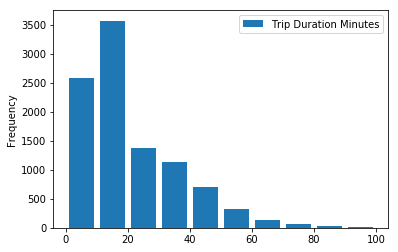

In [14]:
q1.plot(kind='hist',bins=[0,10,20,30,40,50,60,70,80,90,100],rwidth=0.8)

#q1.size().unstack().plot(kind='bar',stacked=True)
plt.show()

## The histogram of ride time distributions is skewed right
The histogram suggests that the majority of Austin B-Cycle rides over time tend to last around 15-20 minutes. Very few rides last over an hour. 

## Graph a line chart of different membership type ride durations over time 

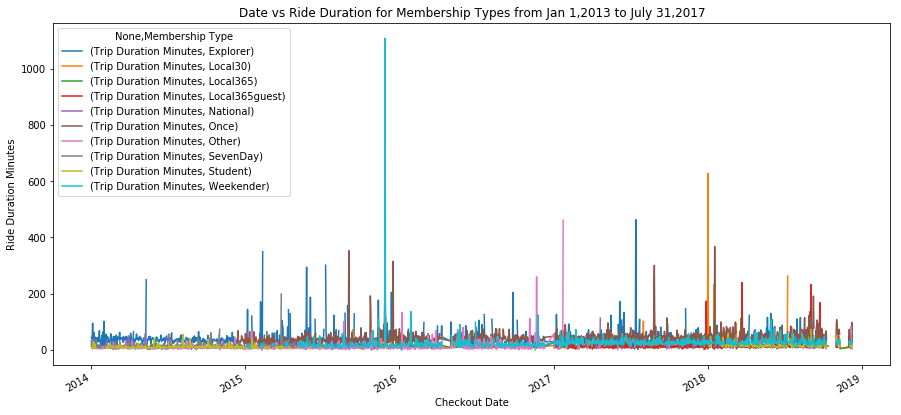

In [16]:
# plot data
fig, ax = plt.subplots(figsize=(15,7))
# use unstack()
q1.unstack().plot(ax=ax)
plt.ylabel('Ride Duration Minutes')
plt.title('Date vs Ride Duration for Membership Types from Jan 1,2013 to July 31,2017')

plt.show() 

## Zoom in to a Ymax of 200 to show bulk of data. 
The spikes may suggest outliers in ride times.

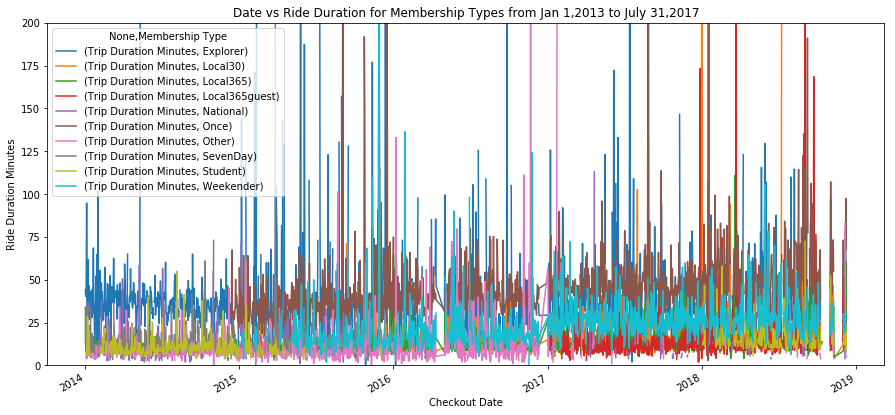

In [17]:
# plot data
fig, ax = plt.subplots(figsize=(15,7))
# use unstack()
q1.unstack().plot(ax=ax)
plt.ylim(top = 200, bottom=0)
plt.ylabel('Ride Duration Minutes')
plt.title('Date vs Ride Duration for Membership Types from Jan 1,2013 to July 31,2017')
plt.show() 

# The aggregate chart shows that there are certain spans of time that had no B-Cycle checkouts at all. 
- See Approximately: April 2016, December 2016, October 2018
- Are these city-wide B-Cycle closures? Maybe for fleet-wide maintenance? 


# The majority of rides are within 60 minutes (or close to it). 
- This makes sense since B-Cycle's pricing model does not charge for a 60 minute ride. A ride over 60 minutes will charge the user. 


# To better visualize the usage data, only the top 4 aggregate membership types will be shown.
- Once
- National
- Student
- Explorer


In [18]:
# use unstack()
qq = q1.unstack()

# remove bottom member types 
qq = qq.drop(columns = [('Trip Duration Minutes', 'Local30'),
 ('Trip Duration Minutes', 'Local365'),
 ('Trip Duration Minutes', 'Local365guest'),
 ('Trip Duration Minutes', 'Other'),
 ('Trip Duration Minutes', 'SevenDay'),
 ('Trip Duration Minutes', 'Weekender')], axis=1)

qq.head() 

Trip Duration Minutes                        
Membership Type              Explorer   National Once Student
Checkout Date                                                
2014-01-01                  43.991770  11.333333  NaN     NaN
2014-01-02                  40.402985        NaN  NaN     NaN
2014-01-03                  46.774900   9.500000  NaN  10.200
2014-01-04                  94.729323   4.000000  NaN   9.800
2014-01-05                  36.454545  10.333333  NaN   6.375

##  NaN values == No Checkout

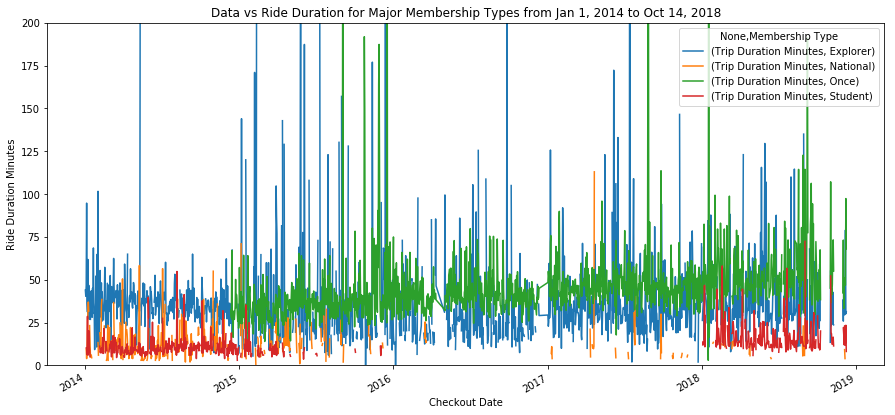

In [19]:
# plot data
fig, ax = plt.subplots(figsize=(15,7))
# use unstack()
qq.plot(ax=ax)
plt.ylim(top = 200, bottom=0)
plt.ylabel('Ride Duration Minutes')
plt.title('Data vs Ride Duration for Major Membership Types from Jan 1, 2014 to Oct 14, 2018')
plt.show() 

## There are significant NaN regions for the different types. 
This might be explained by the dates themselves.

For instance, many students travel out of Austin during Winter Break, which might explain the NaN values for students during the beginning of the year. 

Similarly for the National member group, NaN values during the New Year might be explained by Austin not being a top New Years destination (compared to New York City). 

One-Time and Explorer Member Types appear the more consistent of the four. 
The gap in student Member Type is concerning: were they regrouped? 

## To better visualize the data, the following graphs will show yearly breakdowns. 

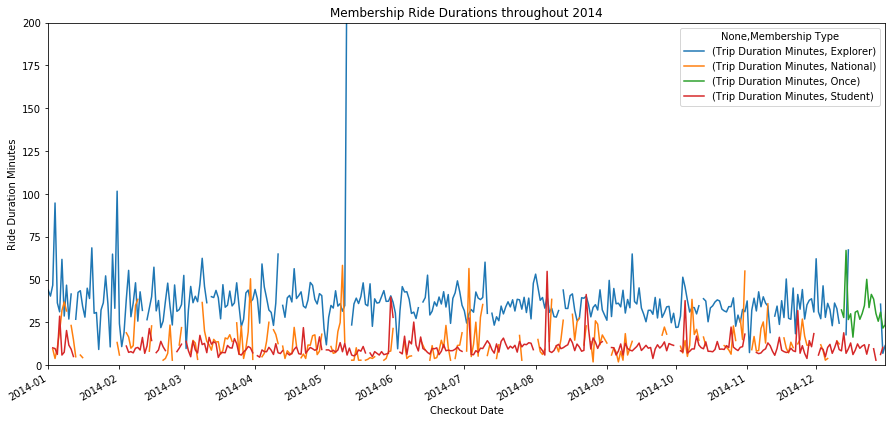

In [20]:
import datetime 

# plot data
fig, ax = plt.subplots(figsize=(15,7))
# use unstack()
qq.plot(ax=ax)
plt.ylim(top = 200, bottom=0)
#plt.xlim(left=0, right = 365)
ax.set_xlim([datetime.date(2014, 1, 1), datetime.date(2014, 12, 31)])
plt.ylabel('Ride Duration Minutes')
plt.title('Membership Ride Durations throughout 2014')

plt.show() 

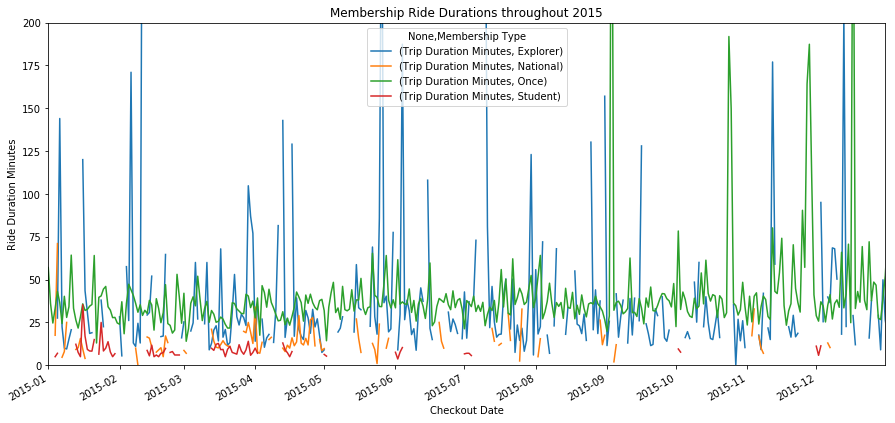

In [21]:
# plot data
fig, ax = plt.subplots(figsize=(15,7))
# use unstack()
qq.plot(ax=ax)
plt.ylim(top = 200, bottom=0)
#plt.xlim(left=366, right = 730)
ax.set_xlim([datetime.date(2015, 1, 1), datetime.date(2015, 12, 31)])
plt.ylabel('Ride Duration Minutes')
plt.title('Membership Ride Durations throughout 2015')
# red lines included to mark 1/3 points in the year 
#plt.axvline(x=485, color='red')
#plt.axvline(x=605, color='red')
plt.show() 

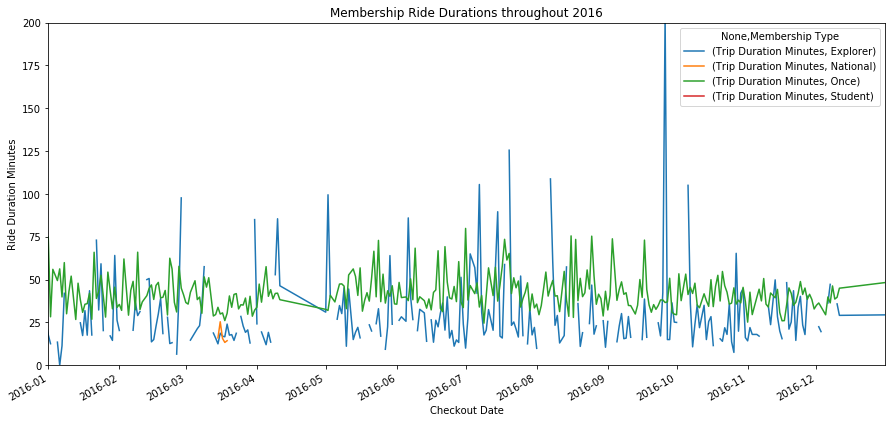

In [22]:
# plot data
fig, ax = plt.subplots(figsize=(15,7))
# use unstack()
qq.plot(ax=ax)
plt.ylim(top = 200, bottom=0)
#plt.xlim(left=731, right = 1096)
ax.set_xlim([datetime.date(2016, 1, 1), datetime.date(2016, 12, 31)])
plt.ylabel('Ride Duration Minutes')
plt.title('Membership Ride Durations throughout 2016') # Leap Year 

plt.show() 

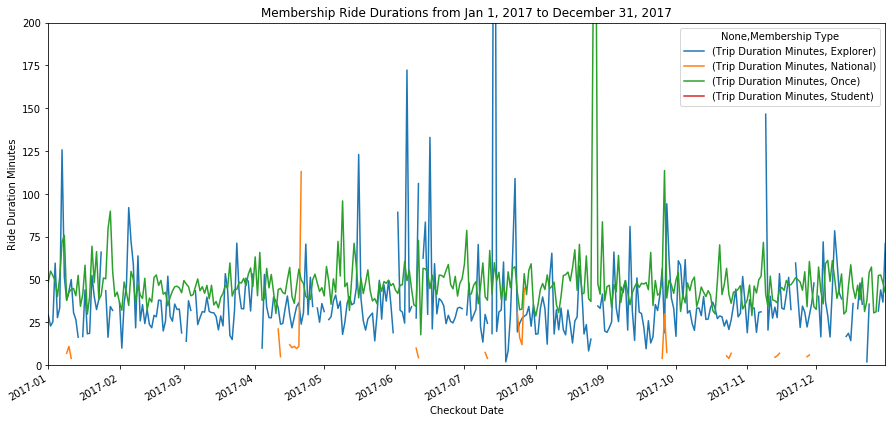

In [24]:
# plot data
fig, ax = plt.subplots(figsize=(15,7))
# use unstack()
qq.plot(ax=ax)
plt.ylim(top = 200, bottom=0)
#plt.xlim(left=1097, right = 1308)
ax.set_xlim([datetime.date(2017, 1, 1), datetime.date(2017, 12, 31)])
plt.ylabel('Ride Duration Minutes')
plt.title('Membership Ride Durations from Jan 1, 2017 to December 31, 2017') # Leap Year

plt.show() 

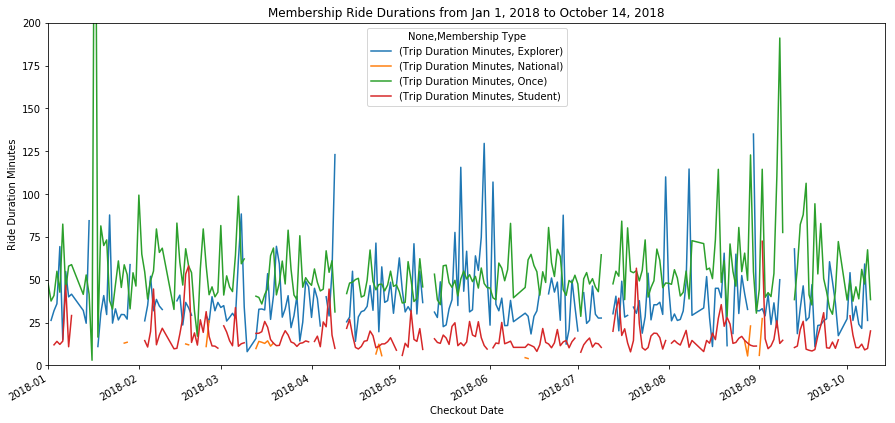

In [25]:
# plot data
fig, ax = plt.subplots(figsize=(15,7))
qq.plot(ax=ax)
plt.ylim(top = 200, bottom=0)
ax.set_xlim([datetime.date(2018, 1, 1), datetime.date(2018, 10, 14)])
plt.ylabel('Ride Duration Minutes')
plt.title('Membership Ride Durations from Jan 1, 2018 to October 14, 2018') 

plt.show() 

# Analysis 
The repeated NaN values in each of the main membership type graphs is concerning. 

Consistenly showing blank values goes against what one would expect, and it begs asking why the data is so. 
- Why are there so many empty data points? It doesn't make sense that an entire one of these membership types would ride on, then off, then on again. 

The provided data does show an average value for each of the top 4 membership types per day. A brief comparison of the median of each type's aggregated mean data is shown below.  

In [26]:
print('Median average ride duration (min) from Jan 1,2013 to Oct 14,2018\n')


print('Explorer:', round(qq['Trip Duration Minutes']['Explorer'].median(),3))
print('National:', round(qq['Trip Duration Minutes']['National'].median(),3))
print('Once:',round(qq['Trip Duration Minutes']['Once'].median(),3))
print('Student:',round(qq['Trip Duration Minutes']['Student'].median(),3))

Median average ride duration (min) from Jan 1,2013 to Oct 14,2018

Explorer: 31.824
National: 11.789
Once: 41.68
Student: 10.716


# Insight: Aggregate 
The above median info and the earlier graphs provide some insight into the relationship between B-Cycle's majority userbases and their actual usage. 

To clarify, the "Once" membership group is what Austin B-Cycle called Walk-Up customers. These single-use riders comprise the largest group, and they also ride the longest of the four major groups. 

National and Explorer (24-hour) members comprise about an even percent of Austin B-Cycle's userbase, but Explorer users ride about 3x more longer than National users in Austin. 

Over the entire time span, the Student group is observed to typically ride 11 minutes at a time. This ride time seems reasonable since a bike ride from the heart of West Campus to the heart of Main Campus is about 10 minutes. 

Overall, these numbers seem consistent with each other. The histogram shows that the overall avereage time should be between 15 and 20 minutes. When weighting an avereage time between the four major member groups' ride durations with their overall percent in the rider pie chart, the weighted avereage ride time is about 17.5 minutes, which lies between 15 and 20 minutes. 

# Look at Member Type Clusters

In [27]:
d_mem = dict(zip(main_members,range(0,10)))
d1test = d1 
d1test = d1test.drop(['Checkout Date'], axis =1)
 
d1.head() 

,Membership Type,Checkout Date,Trip Duration Minutes
0,Explorer,2014-01-01,20
1,Explorer,2014-01-01,19
2,Explorer,2014-01-01,17
3,Explorer,2014-01-01,8
4,Explorer,2014-01-01,18


In [28]:
# transform Mem Type string names into integers 
d1test = d1test.dropna() 

d1test['Membership Type'] = d1test['Membership Type'].map(d_mem, na_action='ignore') 

print(d1test.columns)
d1test.head(20)

Index(['Membership Type', 'Trip Duration Minutes'], dtype='object')


,Membership Type,Trip Duration Minutes
0,0,20
1,0,19
2,0,17
3,0,8
4,0,18
5,0,17
6,0,48
7,0,15
8,0,14
9,0,21


# Data Scaling and Dimensionality Reduction with PCA

Run sklearn.manifold.MDS to project data in 2D and then project clusters. 

In [29]:
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.manifold import MDS

In [30]:
# create standard scaler object for labels only 

#ss = StandardScaler().fit_transform(d1test) # use data for labels only


ss = StandardScaler().fit_transform(d1test['Trip Duration Minutes']) # I think this is the correct way 
# have to reduce trip duration values --> Labels are the 0-9 for the Membership Type 


# create PCA object 
pca = PCA(n_components = .95, svd_solver='full') 
data_pca = pca.fit_transform(ss)

# put transformed data back into a dataframe 
transformed_data = pd.DataFrame(data_pca) 
transformed_data.head(10) 

,0,1
0,-1.392243,1.272608
1,-1.400495,1.264356
2,-1.416999,1.247852
3,-1.491266,1.173585
4,-1.408747,1.256104
5,-1.416999,1.247852
6,-1.161190,1.503661
7,-1.433502,1.231348
8,-1.441754,1.223096
9,-1.383991,1.280860


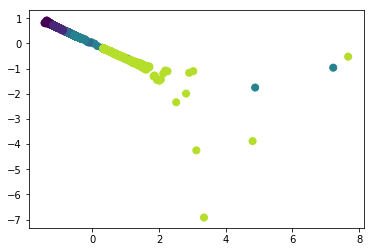

In [32]:
import random as rand
labels = d1test['Membership Type']

def scatter(data, labels, numPoints):
    # numPoints = # rows randomly selected 
    numEntries = data.shape[0]
    start = rand.randint(0, numEntries - numPoints)
    end = start + numPoints
    data = data.iloc[start:end, :]
    labels = labels.iloc[start:end]
    
    mds = MDS(n_components=2)
    mds_data = mds.fit_transform(data.iloc[:, :-1])
    plt.scatter(mds_data[:, 0], mds_data[:, 1], c=labels, s=50)
    plt.show()

    

scatter(transformed_data, labels, numPoints=3000)

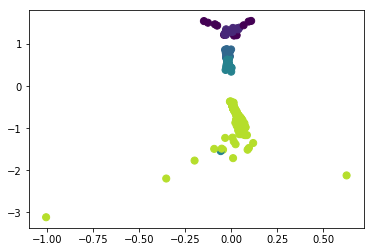

In [33]:
scatter(transformed_data, labels, numPoints=300)

### The plots show three main clusters between member type and ride duration. 

# Cluster with DBSCAN


In [34]:
print(len(transformed_data))
print(type(transformed_data))

1040774
<class 'pandas.core.frame.DataFrame'>


10408


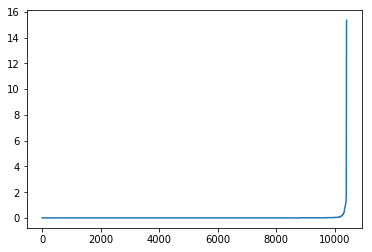

In [35]:
import sklearn as sk 
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import accuracy_score, silhouette_score
from sklearn.model_selection import StratifiedKFold

# sample 1% of the data, about 10000 rows 
transformed_data = transformed_data.sample(frac = .01)

print(len(transformed_data))

# Nearest Neighbors NN sample size is .1% 
nn = NearestNeighbors(10) 

# fit transformed data 
nn_fit = nn.fit(transformed_data)

# K Neighbors method to find distance of each point 
dist, idx = nn_fit.kneighbors(transformed_data)

# only look at distance to 100th nearest neighbor 
dist4 = []
for i in dist: 
    dist4.append(i[9])
dist4.sort() 

# plot distances of fourth nearest neighbor 
plt.plot(dist4)
plt.show() 

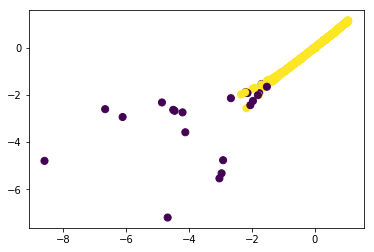

In [37]:
# EPS is about .5 

# DBSCAN fit predict 
clusters = DBSCAN(eps=.5, min_samples = 10).fit_predict(transformed_data)

# convert return to pd series 
ser = pd.Series(clusters) 

# scatter func
scatter(transformed_data, ser, numPoints = 3000)

## Cluster with K Means

In [40]:
#cluster data using K means 
kmeans_2 = KMeans(n_clusters=2).fit_predict(transformed_data)
kmeans_3 = KMeans(n_clusters=3).fit_predict(transformed_data)
kmeans_4 = KMeans(n_clusters=4).fit_predict(transformed_data)
kmeans_5 = KMeans(n_clusters=5).fit_predict(transformed_data)

# convert to series 
ser2 = pd.Series(kmeans_2)
ser3 = pd.Series(kmeans_3)
ser4 = pd.Series(kmeans_4)
ser5 = pd.Series(kmeans_5)

series = [ser2,ser3,ser4,ser5] # K Means results in series 
scores = [] # to hold corresponding silhouette scores 

for i in range (4):
    s_score = silhouette_score(transformed_data, series[i]) 
    print('K:',i+2," Silhouette Score:", s_score)
    scores.append([s_score,i+2])
    
scores.sort(key=lambda x:x[0]) # sort from worst to best score 
print('The best number of clusters is: ', scores[-1][1])

#plot data 
#scatter(transformed_data, ser5)

K: 2  Silhouette Score: 0.5921537753109398
K: 3  Silhouette Score: 0.6085856787612401
K: 4  Silhouette Score: 0.6257569521244966
K: 5  Silhouette Score: 0.6670932777979898
The best number of clusters is:  5


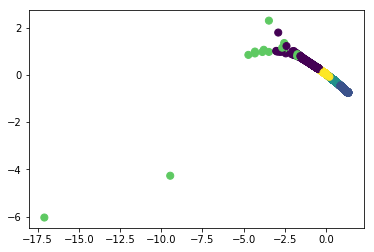

In [42]:
#plot data 
scatter(transformed_data, ser5, numPoints = 3000)

In [ ]:
r_val, p_val = scipy.stats.pearsonr(sample1['Membership Type'], sample1['Trip Duration Minutes'])
r2,p2 = scipy.stats.pearsonr(d1test['Trip Duration Minutes'], transformed_data)

# Q1 Conclusion 
Questions: 

1.Does membership type correlate with ride duration?
- sumn

2.Does a specific membership type ride more or less on average?
- As shown by the yearly pie charts, the member type that rode the most changed over time. 



to-do 
- do a cluster or k means analysis using duration and member type 



# Q2 
Which membership type is riding the most frequently? 

- Y: num rides in a day
- X: time 
- each line will represent a main user base 

In [ ]:
#q2 = data[['Membership Type', 'Checkout Date']]
q2 = data
q2 = q2.groupby('Checkout Date') 




#q2['Membership Type'].value_counts()

#q22 = q2.groupby(['Checkout Date','Membership Type']).count()
#q22.head(20) 

# Q3 
Which are the most/least popular checkout and return kiosks? 
What are the most/least popular destinations? Start-End routes? 
Have there been any changes over time? 

# Q4 
Frequency of checkout vs.
- time of day and month .. stacked bar chart 
- weather .. bar chart 

In [ ]:


#d1test['Membership Type'].map(d_mem, na_action='ignore') 
#d1test['Membership Type'] = d1test['Membership Type'].map(d_mem, na_action='ignore') 

#d1test = d1test.drop(columns=['Checkout Date']) # dropout checkout date 
#d1test = d1test.dropna() 
#d1test.head() 
#r_val, p_val = scipy.stats.pearsonr(sample1['Membership Type'], sample1['Trip Duration Minutes'])

#r_val, p_val = scipy.stats.pearsonr(d1['Membership Type'], d1['Trip Duration Minutes'])
#print('R:',r_val,'\nP:',p_val)

#print(d1['Membership Type'])
#print(d1['Trip Duration Minutes'])
#print(qq)